In [6]:
%cd /nlpgpu/data/artemisp/viunit/visual_unit_testing/
import os
os.environ['PYTHONPATH'] = '/nlpgpu/data/artemisp/visual_unit_testing:$CONDA_PREFIX/'
os.environ['HF_HOME'] = '/nlpgpu/data/artemisp/.cache/huggingface'
os.environ['TORCH_HOME'] = '/nlpgpu/data/artemisp/visual_unit_testing/.cache/'
os.environ['HF_ACCESS_TOKEN'] = '<HF_TOKEN>'
os.environ['HF_TOKEN'] = '<HF_TOKEN>'
os.environ['CUDA_HOME'] = os.environ['CONDA_PREFIX']
os.environ['CONFIG_NAMES'] = 'demo_config'
os.environ["GQA_IMAGE_PATH"] = "/nlp/data/vision_datasets/GQA"
os.environ["WINOGROUND_IMAGE_PATH"] = "/nlp/data/vision_datasets/winoground/data/images"
os.environ["COCO_VAL2017"] = "/nlp/data/vision_datasets/winoground/data/images"

/mnt/nlpgpu-io1/data/artemisp/viunit/visual_unit_testing


In [7]:
# import torch,gc
# gc.collect()
# torch.cuda.empty_cache()

In [3]:
from PIL import Image
import sys
import re
import pickle
import os
import omegaconf
from unit_test_generation.processing import extract_unit_tests, get_unit_test_prompt, get_grounded_diffusion_prompt
from unit_test_generation.unit_test_sampling import TextSampler
from utils import exec_code, extract_python_code
from viper_configs import viper_config
from tqdm import tqdm
import ast
from IPython.display import display
import copy
# from main_simple_lib import *

In [4]:
image_root = os.getenv('GQA_IMAGE_PATH')
# image_root = os.getenv('WINOGROUND_IMAGE_PATH')

def exec_code(image, code):
    code = extract_python_code(code)
    code = ast.unparse(ast.parse(code))
    syntax_2 = Syntax(code, "python", theme="light", line_numbers=True, start_line=0)
    code = code.replace("def execute_command(image)","def execute_command(image, my_fig, time_wait_between_lines, syntax)") 
    if isinstance(image, Image.Image):
        img = image
    elif 'http' in image:
        img = Image.open(requests.get(image, stream=True).raw)
    else:
        img = Image.open(image.replace('/diffusion_unit_tests/', '/stable_diffusion_unit_tests/').replace('/GQA/data/images/', '/GQA/'))
    if img.mode != 'RGB':
        img = img.convert('RGB')
    try:
        execute_code((code, syntax_2), img, show_intermediate_steps=True)
    except Exception as e:
        print(e)

def print_query(data, index):
    if 'index' in data[index]:
        assert index == data[index]['index']
    print("Question: ", data[index]['question'])
    print("Answer: ", data[index]['answer'])
    if os.path.exists(os.path.join(image_root, data[index]['image']+'.jpg')):
        image_path = os.path.join(image_root, data[index]['image']+'.jpg')
    elif os.path.exists(os.path.join(image_root, data[index]['image']+'.png')):
        image_path = os.path.join(image_root, data[index]['image']+'.png')
    Image.open(image_path.replace('/diffusion_unit_tests/', '/stable_diffusion_unit_tests/').replace('/GQA/data/images/', '/GQA/')).resize((128,128)).show()
    
    
def print_unit_tests(data, index, exec=False):
    print("Question: ", data[index]['question'])
    if 'generated_code'  in data[index] and 'selected_unit_tests' in data[index]:
        if isinstance(data[index]['selected_unit_tests'], dict):
            
            for iter in data[index]['generated_code']:
                print("iter: ", iter)
                if 'selected_unit_tests' in data[index]:
                    for i, code in enumerate(data[index]['generated_code'][iter]):
                        print(extract_python_code(code))
                        ut = data[index]['selected_unit_tests'][iter][i]
                        if isinstance(ut, list):
                            for t,u in enumerate(ut):
                                print("Unit test: ", u)
                                for img_idx,img in zip(ut,  data[index]['unit_test_images'][iter][i][t][1]):
                                    if isinstance(img, list):
                                        for im_idx, im in enumerate(img):
                                            im.resize((128,128)).show()
                                            if exec:
                                                exec_code(im, code)
                                            if 'unit_test_results' in data[index]:
                                                print('Unit test acc: ', data[index]['unit_test_results'][iter][i]['results'][t]['results'][im_idx]['acc'])
                                    else:
                                        display(img.resize((128,128)))
                                        if exec:
                                            exec_code(img, code)
                                    if 'unit_test_results' in data[index]:
                                        print('Unit test acc: ', data[index]['unit_test_results'][iter][i]['results'][t]['acc'])
                                
                        else:
                            print('Unit test: ', ut)
                            for im_idx, img in enumerate(data[index]['unit_test_images'][iter][i]):
                                if isinstance(img[1], list):
                                    for im in img[1]:
                                        display(im.resize((128,128)))
                                        if exec:
                                            exec_code(im, code)
                                else:
                                    display(img[1].resize((128,128)))   
                                    if exec:
                                        exec_code(img[1], code)
                                if 'unit_test_results' in data[index]:
                                    print('Unit test acc: ', data[index]['unit_test_results'][iter][i]['results'][t][im_idx]['acc'])
                            if 'unit_test_results' in data[index]:
                                print("Unit test output: ", data[index]['unit_test_results'][iter][i]['results'][t])
                                print('Unit test acc: ', data[index]['unit_test_results'][iter][i]['results'][t]['acc'])
                                    
                            print('-------------------')
        else:
            for iter in data[index]['generated_code']:
                for i, code in enumerate(data[index]['generated_code'][iter]):
                    print(extract_python_code(code))
                    for t, ut in enumerate(data[index]['selected_unit_tests']):
                        print('Unit test: ', ut)
                        if isinstance(data[index]['unit_test_images'][t], tuple):
                            images = data[index]['unit_test_images'][t][1]
                        else:
                            images = [Image.open(im.replace('/diffusion_unit_tests/', '/stable_diffusion_unit_tests/').replace('/GQA/data/images/', '/GQA/')) if not isinstance(im, list) else [Image.open(imm.replace('/diffusion_unit_tests/', '/stable_diffusion_unit_tests/').replace('/GQA/data/images/', '/GQA/')) for imm in im] for im in data[index]['unit_test_images'][t]]
                
                        for img in images:
                            if isinstance(img, list):
                                for im in img:
                                    display(im.resize((128,128)))
                                    if exec:
                                        exec_code(im, code)
                                    if 'unit_test_results' in data[index]:
                                        print('Unit test acc: ', data[index]['unit_test_results'][iter][i]['results'][t][im_idx]['acc'])
                            else:
                                display(img.resize((128,128)))
                                if exec:
                                    exec_code(img, code)
                        if 'unit_test_results' in data[index]:
                            print("Unit test output: ", data[index]['unit_test_results'][iter][i]['results'][t])
                            print('Unit test acc: ', data[index]['unit_test_results'][iter][i]['results'][t]['acc'])
                        print('-------------------')
    else:
        print("No unit tests")
        
                    
def print_codes(data, index, exec=False):
    print("Question: ", data[index]['question'])
    print("Answer: ", data[index]['answer'])
    if 'final_accuracy' in data[index]:
        print("Final Accuracy: ", data[index]['final_accuracy'])
    if os.path.exists(os.path.join(image_root, data[index]['image']+'.jpg')):
        image_path = os.path.join(image_root, data[index]['image']+'.jpg')
    elif os.path.exists(os.path.join(image_root, data[index]['image']+'.png')):
        image_path = os.path.join(image_root, data[index]['image']+'.png')
    elif os.path.exists(os.path.join(image_root, data[index]['image'])):
        image_path = os.path.join(image_root, data[index]['image'])
    image = Image.open(image_path.replace('/diffusion_unit_tests/', '/stable_diffusion_unit_tests/').replace('/GQA/data/images/', '/GQA/'))
    display(image.resize((128,128)))
    for iter in data[index]['generated_code']:
        print('Iteration: ', iter)
        for j, code in enumerate(data[index]['generated_code'][iter]):
            print('-------------------')
            code = extract_python_code(code)
            if exec:
                exec_code(image, code)
            else:
                print(code)
            print('-------------------')

Question:  Is the sandwich in the top of the picture?
def execute_command(image):

Unit test:  ('"A sandwich sitting on the left side of a plate on a table"', 'no')


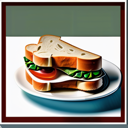

Unit test output:  {'results': [{'error': 'Compilation error: expected an indented block after function definition on line 1 (<unknown>, line 1)', 'output': None, 'acc': -0.0}], 'acc': -0.0}
Unit test acc:  -0.0
-------------------
Unit test:  ('"A delicious-looking sandwich perched on top of a stack of books"', 'yes')


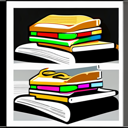

Unit test output:  {'results': [{'error': 'Compilation error: expected an indented block after function definition on line 1 (<unknown>, line 1)', 'output': None, 'acc': -0.0}], 'acc': -0.0}
Unit test acc:  -0.0
-------------------
Unit test:  ('"A bouquet of flowers arranged on a table at the bottom of a grand staircase"', 'no')


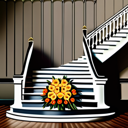

Unit test output:  {'results': [{'error': 'Compilation error: expected an indented block after function definition on line 1 (<unknown>, line 1)', 'output': None, 'acc': -0.0}], 'acc': -0.0}
Unit test acc:  -0.0
-------------------
Unit test:  ('"A delicious-looking cake situated at the bottom of a tiered dessert stand"', 'no')


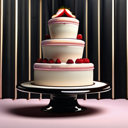

Unit test output:  {'results': [{'error': 'Compilation error: expected an indented block after function definition on line 1 (<unknown>, line 1)', 'output': None, 'acc': -0.0}], 'acc': -0.0}
Unit test acc:  -0.0
-------------------
Unit test:  ('"A simple bowl of fruit sitting at the top of a kitchen counter"', 'yes')


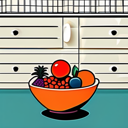

Unit test output:  {'results': [{'error': 'Compilation error: expected an indented block after function definition on line 1 (<unknown>, line 1)', 'output': None, 'acc': -0.0}], 'acc': -0.0}
Unit test acc:  -0.0
-------------------


In [8]:
data = pickle.load(open('/nlpgpu/data/artemisp/viunit/visual_unit_testing/output/test/data.p', 'rb'))
print_unit_tests(data, 0, exec=False)